**Module 4 Project Questions, Answers, Code**
1. Data Cleaning / Exploratory Visualization / Feature Engineering / Modeling: ran a new model with less pipeline complexity, ran further exploratory visualizations.
2. 1 Partial Dependence plot: PDP of BMI and Sleep Hours which were the highest and lowest perm importances, respectively. The plot shows a delta of 15 points for someone with a BMI of 1 vs 2; compared to Sleep Hours which has a delta of 5 points between 1 hour of sleep and 10 hours of sleep.
3. 1 Shapley force plot to explain an individual prediction: Ran 2, one for the head(1) and one for tail(1). Interestingly, the tail shapley plot had the individual with a healthly BMI (i.e., the most influential feature) but a lower predicted target score than the head shapley plot that had an individual with an unhealthy BMI score. Both individuals had sufficient income. But the healthy BMI person had the worst possible vacation days lost (10 days) and the worst score possible for new places visited in the past year (0), both of which are amongst the top 5 most influential features. 
4. Share 1 Visualization on Slack: Shared horizontal bar chart in slack channel. 


**Module 3 Project Questions, Answers, Code**
1. Exploratory Visualizations --> Ran a horizontal bar chart illustrating feature importances ranked by highest coefficients, BMI was the strongest relationship with the target variable, followed by sufficient income; sadly, meditation was lower in the rankings (but above fuits and veggies :) )
2. Fit a model --> ran both Ridge and LR models using pipeline with OneHotEncoder, SimpleImputer, and StandardScaler; Ridge performed too well, LR performed terribly
3.  Try xgboost: XGBoost model performed very well, with a mean abosolute error of 4 points, relative to the baseline of 36 points
4. Model Permutation Importances: Perhaps unsurprisingly, the feature importances were highest amongst BMI, Sufficient Income, and a near 3-way tie across Lost Vacation, Supporting Others, and Donation


**Module 2 Project Questions, Answers, Code**

1. Clean / Explore Data Further --> updates to daily stress feature to make it an int not an object, and update gender to be a binary 0 or 1 column vs string Male and Female
2. Using mean absolute error, the baseline MAE from guessing is 36 points (for the target variable which has a mean of ~660 and a range of 480 to 820)
3. Ridge model has an MAE of near-zero vs linear regression which is far worse than the baseline guessing; given how accurate it is though, will look into any potential leakage that might be occuring



**Module 1 Project Questions, Answers, Code**

1. Prediction column = WORK_LIFE_BALANCE_SCORE
2. Regression problem
3. Target Distribution ranges from 480 to 820, higher score means a more well balances work and lifestyle
4. No inherent classifications
5. Target is not right-skewed, it's mean is directly in the middle of it's min and max
6. I will be using both mean absolute error and R squared metrics in evaluating baseline vs model performances
7. I will initially be using all features to train the model and finetune according to feature importances; it will be a random split as timing does not have a strong impact on results


In [ ]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
;

In [ ]:
# Imports to bring data in
from google.colab import files
import io
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap
from sklearn.metrics import plot_confusion_matrix, classification_report
# cross validation
from sklearn.model_selection import cross_val_score
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
uploaded = files.upload()

Saving Wellbeing_and_lifestyle_data_Kaggle 2.csv to Wellbeing_and_lifestyle_data_Kaggle 2.csv


In [ ]:
def classifier(row):
  if row['WORK_LIFE_BALANCE_SCORE'] < 550:
    return 'Poor Score'
  elif row['WORK_LIFE_BALANCE_SCORE'] < 680:
    return 'Average Score'
  elif row['WORK_LIFE_BALANCE_SCORE'] < 700:
    return 'Good Score'
  else:
    return 'Excellent Score'

def wrangle(filepath):
  df = pd.read_csv(io.BytesIO(uploaded[filepath]))

  # Set time column to datetime format
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], infer_datetime_format=True)
  
  # Set index as the timestamp column
  df.set_index('Timestamp', inplace=True)
  
  # Clean daily stress data and set as int vs object
  df['DAILY_STRESS'].replace('1/1/00', '1', inplace=True)
  df['DAILY_STRESS'] = df['DAILY_STRESS'].astype(int)
  
  # Encode Gender to be 1 for male and 0 for female
  df["GENDER"] = np.where(df["GENDER"].str.contains("Male"), 1, 0)
  
  # CLASSIFY target column
  df['TARGET_CLASSIFICATION'] = df.apply(classifier, axis=1)

  # Drop Leaky Columns
  df = df.drop(columns=['BMI_RANGE', 'SUFFICIENT_INCOME'])

  return df

In [ ]:
filepath = 'Wellbeing_and_lifestyle_data_Kaggle 2.csv'
df = wrangle(filepath)


df_regression = df.drop(columns='TARGET_CLASSIFICATION')
df_train_regression = df_regression.tail((15972 - 1597))
df_test_regression = df_regression.head(1597)
regression_X_test = df_test_regression.drop(columns='WORK_LIFE_BALANCE_SCORE')
regression_y_test = df_test_regression['WORK_LIFE_BALANCE_SCORE']

df_classification = df.drop(columns='WORK_LIFE_BALANCE_SCORE')
df_train_classification = df_classification.tail((15972 - 1597))
df_test_classification = df_classification.head(1597)
class_X_test = df_test_classification.drop(columns='TARGET_CLASSIFICATION')
class_y_test = df_test_classification['TARGET_CLASSIFICATION']

print(df_train_regression.shape, df_test_regression.shape, df_train_classification.shape, df_test_classification.shape)
df_train_regression.head()

(14375, 21) (1597, 21) (14375, 21) (1597, 21)


,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,TODO_COMPLETED,FLOW,DAILY_STEPS,LIVE_VISION,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION,AGE,GENDER,WORK_LIFE_BALANCE_SCORE
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-11-14,5,2,7,10,10,6,10,1,8,7,8,10,8,4,0,3,7,10,21 to 35,0,731.0
2015-11-14,1,3,2,4,3,10,4,0,3,4,2,2,8,1,0,3,3,3,36 to 50,0,641.4
2015-11-14,2,2,2,4,4,10,3,0,3,3,2,2,8,0,0,3,3,3,36 to 50,0,648.2
2015-11-14,5,4,9,5,10,10,10,2,6,1,5,3,8,0,2,8,2,4,36 to 50,0,708.3
2015-11-14,2,4,5,5,7,10,6,3,0,5,7,7,8,3,2,8,4,2,Less than 20,0,667.9


In [ ]:
print(df.index.dtype)

df.describe()

datetime64[ns]


,FRUITS_VEGGIES,DAILY_STRESS,PLACES_VISITED,CORE_CIRCLE,SUPPORTING_OTHERS,SOCIAL_NETWORK,ACHIEVEMENT,DONATION,TODO_COMPLETED,FLOW,DAILY_STEPS,LIVE_VISION,SLEEP_HOURS,LOST_VACATION,DAILY_SHOUTING,PERSONAL_AWARDS,TIME_FOR_PASSION,WEEKLY_MEDITATION,GENDER,WORK_LIFE_BALANCE_SCORE
count,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000,15972.000000
mean,2.922677,2.791573,5.232970,5.508077,5.616454,6.474267,4.000751,2.715314,5.745993,3.194778,5.703606,3.752129,7.042888,2.898886,2.930879,5.711558,3.326572,6.233346,0.382795,666.751503
std,1.442694,1.367831,3.311912,2.840334,3.242021,3.086672,2.755837,1.851586,2.624097,2.357518,2.891013,3.230987,1.199044,3.692180,2.676301,3.089630,2.729293,3.016571,0.486084,45.019868
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,480.000000
25%,2.000000,2.000000,2.000000,3.000000,3.000000,4.000000,2.000000,1.000000,4.000000,1.000000,3.000000,1.000000,6.000000,0.000000,1.000000,3.000000,1.000000,4.000000,0.000000,636.000000
50%,3.000000,3.000000,5.000000,5.000000,5.000000,6.000000,3.000000,3.000000,6.000000,3.000000,5.000000,3.000000,7.000000,0.000000,2.000000,5.000000,3.000000,7.000000,0.000000,667.700000
75%,4.000000,4.000000,8.000000,8.000000,10.000000,10.000000,6.000000,5.000000,8.000000,5.000000,8.000000,5.000000,8.000000,5.000000,4.000000,9.000000,5.000000,10.000000,1.000000,698.500000
max,5.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,5.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,820.200000


In [ ]:
target_regression = 'WORK_LIFE_BALANCE_SCORE'
X_reg = df_train_regression.drop(columns=target_regression)
y_reg = df_train_regression[target_regression]

target_classification = 'TARGET_CLASSIFICATION'
X_clas = df_train_classification.drop(columns=target_classification)
y_clas = df_train_classification[target_classification]

In [ ]:
X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(X_reg, y_reg, train_size=0.9)

X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_clas, y_clas, train_size=0.9)


In [ ]:
# Regression Baseline
y_pred_baseline = [y_reg.mean()] * len(y_reg)
baseline_mae = mean_absolute_error(y_reg, y_pred_baseline)
print('Regression Baseline MAE:', baseline_mae)

# Classification Baseline
baseline_acc = y_clas.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Regression Baseline MAE: 36.074331749625664
Baseline Accuracy Score: 0.6032695652173913


In [ ]:
y_clas.value_counts(normalize=True)

Average Score      0.603270
Excellent Score    0.236035
Good Score         0.156243
Poor Score         0.004452
Name: TARGET_CLASSIFICATION, dtype: float64

In [ ]:
model_lr = make_pipeline(OneHotEncoder(use_cat_names=True),
                         SimpleImputer(),
                         StandardScaler(),
                         LinearRegression())

model_lr.fit(X_train_r, y_train_r);

In [ ]:
model_r = make_pipeline(OneHotEncoder(use_cat_names=True),
                        SimpleImputer(strategy='most_frequent'),
                        StandardScaler(),
                        Ridge(alpha=1, random_state=42))
model_r.fit(X_train_r, y_train_r);

In [ ]:
model_lr_mae_train = mean_absolute_error(y_train_r, model_lr.predict(X_train_r))
model_lr_mae_val = mean_absolute_error(y_val_r, model_lr.predict(X_val_r))

model_r_mae_train = mean_absolute_error(y_train_r, model_r.predict(X_train_r))
model_r_mae_val = mean_absolute_error(y_val_r, model_r.predict(X_val_r))

print('LR Train MAE:', model_lr_mae_train, '\n', 'LR Val MAE:', model_lr_mae_val, '\n', 'Ridge Train MAE:', model_r_mae_train, '\n', 'Ridge Val MAE:', model_r_mae_val)

model_lr_mae_test = mean_absolute_error(regression_y_test, model_lr.predict(regression_X_test))
model_r_mae_test = mean_absolute_error(regression_y_test, model_r.predict(regression_X_test))

print('LR Test MAE:', model_lr_mae_test, '\n', 'Ridge Test MAE:', model_r_mae_test)

LR Train MAE: 9.082308564951258 
 LR Val MAE: 9.173639400373418 
 Ridge Train MAE: 9.076583607244306 
 Ridge Val MAE: 9.170424186568399
LR Test MAE: 9.276880207519794 
 Ridge Test MAE: 9.2811766292468


In [ ]:
from xgboost import XGBClassifier

model_x = make_pipeline(OneHotEncoder(use_cat_names=True),
                        SimpleImputer(),
                        StandardScaler(),
                        XGBClassifier(random_state=42, n_jobs=-1))

model_x.fit(X_train_c, y_train_c);

In [ ]:
model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='median'),
                         RandomForestClassifier(random_state=42, n_jobs=-1))
model_rf.fit(X_train_c, y_train_c);

In [ ]:
class_xgb_training_acc = accuracy_score(y_train_c, model_x.predict(X_train_c))
class_xgb_val_acc = accuracy_score(y_val_c, model_x.predict(X_val_c))
class_xgb_test_acc = accuracy_score(class_y_test, model_x.predict(class_X_test))

print('XGB Training Accuracy Score:', class_xgb_training_acc)
print('XGB Validation Accuracy Score:', class_xgb_val_acc)
print('XGB Test Accuracy Score:', class_xgb_test_acc, '\n')

class_rfc_training_acc = accuracy_score(y_train_c, model_rf.predict(X_train_c))
class_rfc_val_acc = accuracy_score(y_val_c, model_rf.predict(X_val_c))
class_rfc_test_acc = accuracy_score(class_y_test, model_rf.predict(class_X_test))

print('RFC Training Accuracy Score:', class_rfc_training_acc)
print('RFC Validation Accuracy Score:', class_rfc_val_acc)
print('RFC Test Accuracy Score:', class_rfc_test_acc)

XGB Training Accuracy Score: 0.85699930432094
XGB Validation Accuracy Score: 0.8212795549374131
XGB Test Accuracy Score: 0.8409517845961177 

RFC Training Accuracy Score: 1.0
RFC Validation Accuracy Score: 0.8296244784422809
RFC Test Accuracy Score: 0.8121477770820288


In [ ]:
param_grid = {'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
              'randomforestclassifier__max_depth': range(10, 30, 1),
              'randomforestclassifier__n_estimators': range(50, 201, 7),
              'randomforestclassifier__max_features': range(4, 10, 1),
              'randomforestclassifier__random_state': range(40, 50, 1)}


model = RandomizedSearchCV(model_rf, 
                             param_distributions=param_grid, 
                             n_iter=50, 
                             n_jobs=-1, 
                             cv=5, 
                             verbose=10)

model.fit(X_train_c, y_train_c);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4

In [ ]:
best_score = model.best_score_
best_params = model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)

Best score for `model`: 0.8267753283119916
Best params for `model`: {'simpleimputer__strategy': 'most_frequent', 'randomforestclassifier__random_state': 47, 'randomforestclassifier__n_estimators': 155, 'randomforestclassifier__max_features': 8, 'randomforestclassifier__max_depth': 22}


In [ ]:
param_grid = {'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
              'xgbclassifier__max_depth': range(10, 30, 1),
              'xgbclassifier__n_estimators': range(50, 201, 7),
              'xgbclassifier__max_features': range(4, 10, 1),
              'xgbclassifier__random_state': range(40, 50, 1)}


model = RandomizedSearchCV(model_x, 
                             param_distributions=param_grid, 
                             n_iter=50, 
                             n_jobs=-1, 
                             cv=5, 
                             verbose=10)

model.fit(X_train_c, y_train_c);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 34

In [ ]:
xgb_best_score = model.best_score_
xgb_best_params = model.best_params_

print('Best score for `model`:', xgb_best_score)
print('Best params for `model`:', xgb_best_params)

Best score for `model`: 0.8444764543201083
Best params for `model`: {'xgbclassifier__random_state': 43, 'xgbclassifier__n_estimators': 190, 'xgbclassifier__max_features': 4, 'xgbclassifier__max_depth': 28, 'simpleimputer__strategy': 'median'}


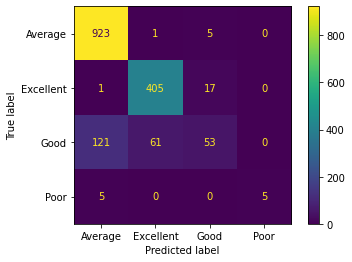

In [ ]:
plot_confusion_matrix(model_x, 
                      class_X_test, 
                      class_y_test,
                      values_format='.0f',
                      display_labels=['Average', 'Excellent', 'Good', 'Poor'])

In [ ]:
print(classification_report(class_y_test, model_rf.predict(class_X_test)))

class_y_test.value_counts()

                 precision    recall  f1-score   support

  Average Score       0.82      0.98      0.89       929
Excellent Score       0.86      0.84      0.85       423
     Good Score       0.39      0.13      0.19       235
     Poor Score       1.00      0.30      0.46        10

       accuracy                           0.81      1597
      macro avg       0.77      0.56      0.60      1597
   weighted avg       0.77      0.81      0.78      1597



Average Score      929
Excellent Score    423
Good Score         235
Poor Score          10
Name: TARGET_CLASSIFICATION, dtype: int64

Text(0.5, 1.0, 'Coefficients for Ridge Regression')

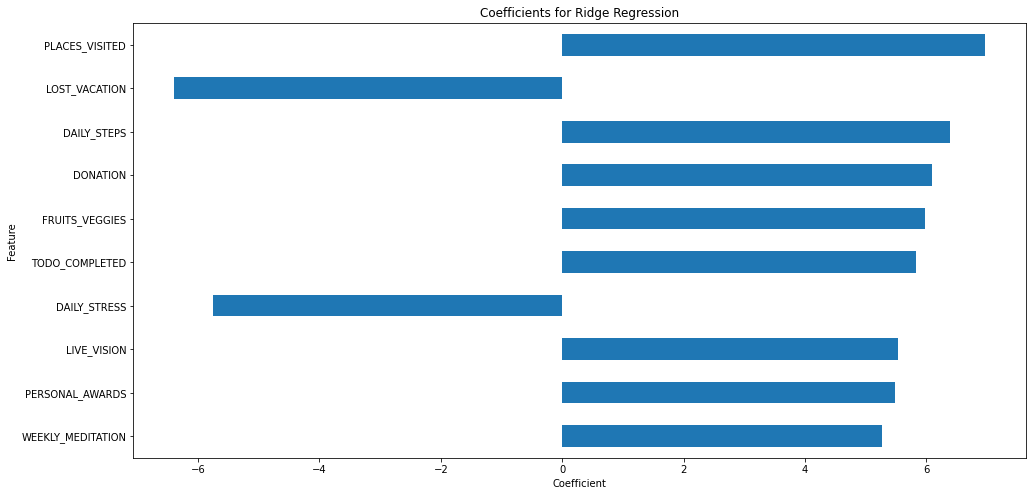

In [ ]:
# Create your horizontal barchart here.
from matplotlib.pyplot import figure

coefficients = model_r.named_steps['ridge'].coef_
# coefficients = coefficients.flatten()
features = model_r.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh', figsize=(16,8))
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression')

In [ ]:
feat_imp

AGE_36 to 50         0.000021
GENDER              -0.000159
AGE_Less than 20     0.000457
AGE_51 or more       0.001077
AGE_21 to 35        -0.001284
SLEEP_HOURS          2.323173
FLOW                 4.003849
TODO_COMPLETED       4.463168
DAILY_STRESS        -4.466985
DAILY_SHOUTING      -4.619458
TIME_FOR_PASSION     4.671487
ACHIEVEMENT          4.718396
CORE_CIRCLE          4.857296
FRUITS_VEGGIES       4.916215
WEEKLY_MEDITATION    5.028756
SOCIAL_NETWORK       5.250818
PERSONAL_AWARDS      5.320230
LIVE_VISION          5.486868
SUPPORTING_OTHERS    5.512100
PLACES_VISITED       5.573189
DAILY_STEPS          5.589041
DONATION             6.124838
LOST_VACATION       -6.193920
SUFFICIENT_INCOME    7.586240
BMI_RANGE           -8.277536
dtype: float64

In [ ]:
from xgboost import XGBRegressor

model_x = make_pipeline(OneHotEncoder(use_cat_names=True),
                        SimpleImputer(),
                        StandardScaler(),
                        XGBRegressor())

model_x.fit(X_train, y_train);

[23:20:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
model_x_mae_train = mean_absolute_error(y_train, model_x.predict(X_train))
model_x_mae_val = mean_absolute_error(y_val, model_x.predict(X_val))

print('LR Train MAE:', model_lr_mae_train, '\n', 'LR Val MAE:', model_lr_mae_val, '\n', 'Ridge Train MAE:', model_r_mae_train, '\n', 'Ridge Val MAE:', model_r_mae_val, '\n', 'XGBoost Train MAE:', model_x_mae_train, '\n', 'XGBoost Val MAE:', model_x_mae_val)

LR Train MAE: 9.038083366751511 
 LR Val MAE: 9.722839782023721 
 Ridge Train MAE: 9.03918499201395 
 Ridge Val MAE: 9.724667691455119 
 XGBoost Train MAE: 7.060243848403793 
 XGBoost Val MAE: 9.892340774536134


In [ ]:
from sklearn.inspection import permutation_importance

# LR
perm_imp_lr = permutation_importance(model_lr,
                                     regression_X_test,
                                     regression_y_test,
                                     n_repeats=5,
                                     n_jobs = -1,
                                     random_state = 42)

data = {'imp_mean': perm_imp_lr.importances_mean,
        'imp_std' : perm_imp_lr.importances_std}

perm_imp_lr = pd.DataFrame(data, index=regression_X_test.columns)

# Ridge
perm_imp_r = permutation_importance(model_r,
                                     regression_X_test,
                                     regression_y_test,
                                     n_repeats=5,
                                     n_jobs = -1,
                                     random_state = 42)

data = {'imp_mean': perm_imp_r.importances_mean,
        'imp_std' : perm_imp_r.importances_std}

perm_imp_r = pd.DataFrame(data, index=regression_X_test.columns)

# XGBoost
perm_imp_x = permutation_importance(model_x,
                                     class_X_test,
                                     class_y_test,
                                     n_repeats=5,
                                     n_jobs = -1,
                                     random_state = 42)

data = {'imp_mean': perm_imp_x.importances_mean,
        'imp_std' : perm_imp_x.importances_std}

perm_imp_x = pd.DataFrame(data, index=class_X_test.columns)

# Show Perm Imp for all three models
perm_imp_lr, perm_imp_r, perm_imp_x

(                   imp_mean   imp_std
 FRUITS_VEGGIES     0.030909  0.001947
 DAILY_STRESS       0.026405  0.001913
 PLACES_VISITED     0.044677  0.000728
 CORE_CIRCLE        0.022902  0.001465
 SUPPORTING_OTHERS  0.026898  0.000668
 SOCIAL_NETWORK     0.031212  0.001675
 ACHIEVEMENT        0.021155  0.000695
 DONATION           0.034228  0.000487
 TODO_COMPLETED     0.029922  0.001856
 FLOW               0.010144  0.000958
 DAILY_STEPS        0.045427  0.002136
 LIVE_VISION        0.034548  0.001219
 SLEEP_HOURS        0.006022  0.000762
 LOST_VACATION      0.044895  0.002860
 DAILY_SHOUTING     0.024565  0.000570
 PERSONAL_AWARDS    0.028562  0.000798
 TIME_FOR_PASSION   0.015864  0.001372
 WEEKLY_MEDITATION  0.023080  0.000801
 AGE                0.000430  0.000239
 GENDER             0.000030  0.000078,                    imp_mean   imp_std
 FRUITS_VEGGIES     0.031600  0.001995
 DAILY_STRESS       0.026378  0.001932
 PLACES_VISITED     0.044399  0.000714
 CORE_CIRCLE        0.022

In [ ]:
perm_imp_x

,imp_mean,imp_std
FRUITS_VEGGIES,0.025924,0.002899
DAILY_STRESS,0.019036,0.003374
PLACES_VISITED,0.023669,0.001916
CORE_CIRCLE,0.012273,0.003599
SUPPORTING_OTHERS,0.020038,0.003715
SOCIAL_NETWORK,0.018034,0.003251
ACHIEVEMENT,0.016281,0.002376
DONATION,0.019411,0.004550
TODO_COMPLETED,0.020789,0.003393
FLOW,0.007639,0.000614


(<Figure size 1080x1224 with 9 Axes>,
 {'pdp_inter_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f7d02e980d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7d03a0c1d0>})

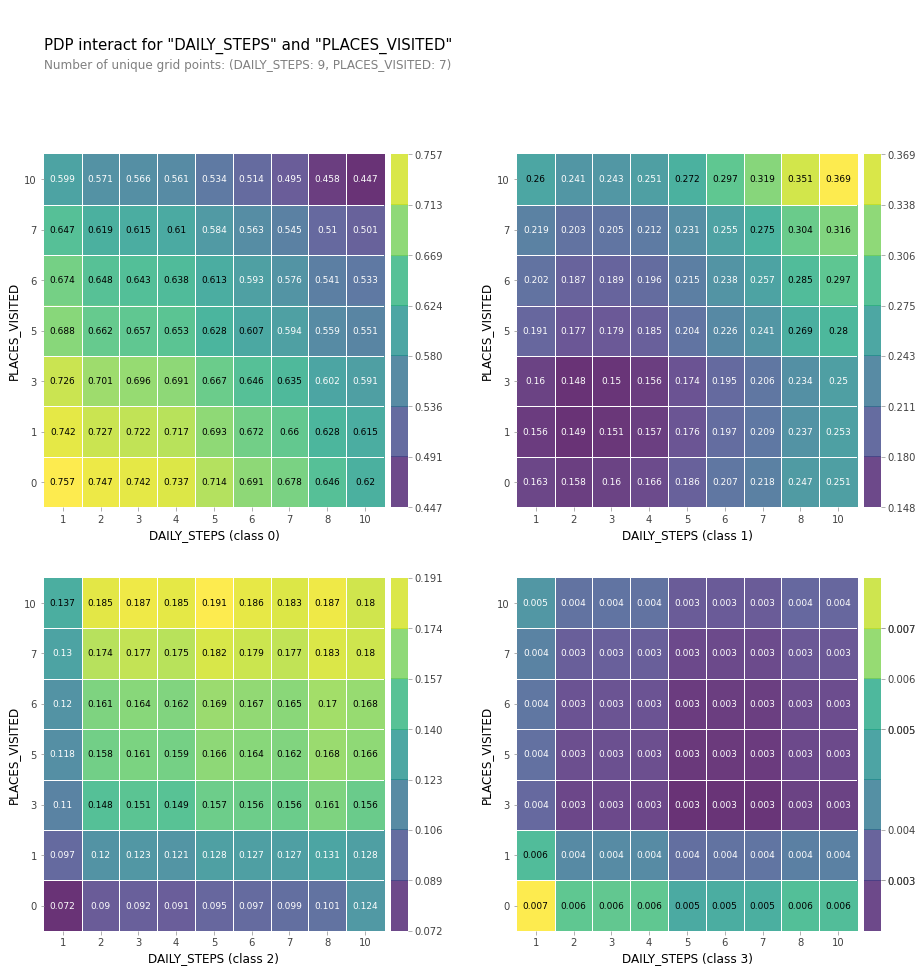

In [ ]:
features = ['DAILY_STEPS', 'PLACES_VISITED']
# YOUR CODE HERE

interact = pdp_interact(model_x,
                        dataset=class_X_test.dropna(),
                        model_features=class_X_test.columns,
                        features=features)
pdp_interact_plot(interact, plot_type='grid', feature_names=features)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7d02fa8e10>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f7d044480d0>})

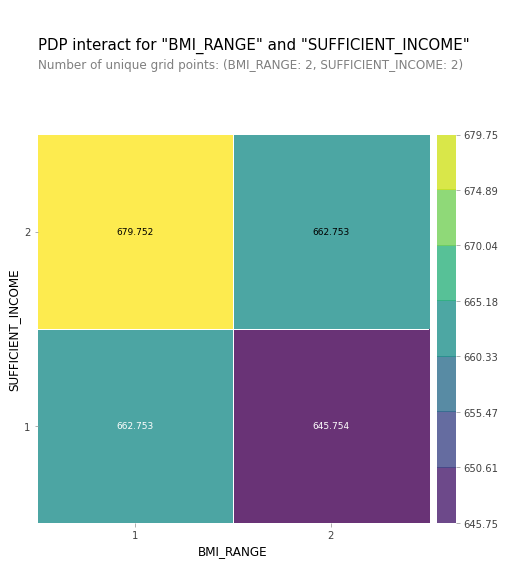

In [ ]:
features = ['BMI_RANGE', 'SUFFICIENT_INCOME']
# YOUR CODE HERE

interact = pdp_interact(model_r,
                        dataset=regression_X_test.dropna(),
                        model_features=regression_X_test.columns,
                        features=features)
pdp_interact_plot(interact, plot_type='grid', feature_names=features)

In [ ]:
model_gb = LinearRegression()
model_gb.fit(X_val_r, y_val_r);


row = X_val_r.tail(1)

explainer = shap.Explainer(model_gb)
shap_values = explainer.shap_values(row)

shap.initjs()

shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features=row
)

ValueError: ignored

In [ ]:
row = X_val.head(1)

explainer = shap.Explainer(model_gb)
shap_values = explainer.shap_values(row)

shap.initjs()

shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features=row
)

In [ ]:
param_grid = {'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
              'ridge__alpha': range(1, 15, 3),
              'ridge__fit_intercept': ['True', 'False'],
              'ridge__normalize': ['True', 'False'],
              'ridge__random_state': range(0, 50, 10)}


model_rid = RandomizedSearchCV(model_r, 
                             param_distributions=param_grid, 
                             n_iter=50, 
                             n_jobs=-1, 
                             cv=5, 
                             verbose=10)

model_rid.fit(X,y)

# alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1910s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0990s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    7.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=[],
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=True,
                                                            verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,
    

In [ ]:
rid_best_score = model_rid.best_score_
rid_best_params = model_rid.best_params_

print('Best score for `model`:', rid_best_score)
print('Best params for `model`:', rid_best_params)

Best score for `model`: 0.898047194204459
Best params for `model`: {'simpleimputer__strategy': 'most_frequent', 'ridge__random_state': 30, 'ridge__normalize': 'True', 'ridge__fit_intercept': 'False', 'ridge__alpha': 1}


In [ ]:
param_grid = {'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
              'randomforestclassifier__max_depth': range(10, 30, 1),
              'randomforestclassifier__n_estimators': range(50, 201, 7),
              'randomforestclassifier__max_features': range(4, 10, 1),
              'randomforestclassifier__random_state': range(40, 50, 1)}


model = RandomizedSearchCV(clf_rf, 
                             param_distributions=param_grid, 
                             n_iter=50, 
                             n_jobs=-1, 
                             cv=8, 
                             verbose=10)

model.fit(X,y)

ax_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, importance_type='gain', **kwargs)


In [ ]:
best_score = model.best_score_
best_params = model.best_params_

print('Best score for `model`:', best_score)
print('Best params for `model`:', best_params)